Additional experiment on Syn-Boost with transfer learning.

In [1]:
import torch
cuda_device = "cuda:0"
torch.cuda.set_device(cuda_device)

from torch.utils.data import Dataset, DataLoader
from torch import nn


import pickle
from copy import deepcopy
from utils_syninf import *
from utils_num import *

from tqdm import tqdm

from scipy.interpolate import splrep, BSpline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

from lightning.pytorch import seed_everything

SEED = 2023
plt.style.use("bmh")

In [2]:
class MySpline:
    def __init__(self, x, y, n_interior_knots=5, k=3):
        """
        1-d B-spline for spline smoothing.
        x: numpy array of shape (n, 1)
        y; numpy array of shape (n, )
        n_interior_knots: number of interior knots (-> quantile of x as interior knots of the spline)
        k: degree of the spline fit (e.g. 3 for cubic spline)
        """

        # specify spline knots based on quantiles of x
        qs = np.linspace(0, 1, n_interior_knots + 2)[1:-1]
        knots = np.quantile(x, qs)
        t, c, k = splrep(x, y, t=knots, k=k)

        dmatrix_raw = BSpline.design_matrix(x.reshape(-1), t, k).toarray()
        xtx = np.linalg.pinv(dmatrix_raw.T @ dmatrix_raw)
        beta_hat = xtx @ dmatrix_raw.T @ y

        sigma_hat = np.sqrt(
            np.sum((y - dmatrix_raw @ beta_hat) ** 2) / (len(y) - len(beta_hat))
        )

        self.tck = (t, c, k)
        self.dmatrix_raw = dmatrix_raw
        self.xtx = xtx
        self.beta_hat = beta_hat
        self.sigma_hat = sigma_hat

    def pred(self, x):
        """Predict y given x using beta_hat (estimated from spline) and get SE for the prediction"""
        if len(x.shape) == 2 and x.shape[1] == 1:
            x = x.reshape(-1)
        dmatrix = BSpline.design_matrix(x, self.tck[0], self.tck[2]).toarray()

        y_pred = dmatrix @ self.beta_hat
        y_pred_se = self.sigma_hat * np.diag(dmatrix @ self.xtx @ dmatrix.T)

        return y_pred, y_pred_se



class Adult(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        """
        X should be a torch tensor of shape (n, d), where:
        - numerical features are already quantile transformed
        - categorical features are already one-hot encoded
        """
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [3]:

def gender_transform_x_y(df: pd.DataFrame, transform: ColumnTransformer):
    """
    Transform the data using the pipeline and return X and y
    - X will be a torch tensor of shape (n, d)
    - y will be a torch tensor of shape (n, )
    """
    X = torch.tensor(transform.transform(df).toarray(), dtype=torch.float32)
    y = torch.tensor(df[gender_names_dict["y_feature"]].to_numpy(dtype=int))
    return X, y


def mlp_val_epoch(model, val_dl, **kwargs):
    """
    Validate at the end of each epoch
    - model, val_dl: the model and the validation dataloader
    """
    model.eval()
    
    val_loss = []
    val_correct, val_total = 0, 0
    for X, y in val_dl:
        X, y = X.to(kwargs["cuda_device"]), y.to(kwargs["cuda_device"])
        y_pred = model(X)
        loss = kwargs["loss_fn"](y_pred, y)

        val_loss.append(loss.item())
        val_total += y.shape[0]
        val_correct += (y_pred.argmax(dim=1) == y).sum().item()

    return np.mean(val_loss), val_correct / val_total


def mlp_train_epoch(model, train_dl, optimizer, **kwargs):
    """
    Train the MLP model for one_epoch
    - model, train_dl: the model and the training dataloader
    """
    model.train()
    
    train_loss = []
    train_correct, train_total = 0, 0
    for X, y in train_dl:
        X, y = X.to(kwargs["cuda_device"]), y.to(kwargs["cuda_device"])
        y_pred = model(X)
        loss = kwargs["loss_fn"](y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_total += y.shape[0]
        train_correct += (y_pred.argmax(dim=1) == y).sum().item()
    
    return np.mean(train_loss), train_correct / train_total


In [4]:
dataset_name = "adult"
dataset_dir = os.path.join(TDDPM_DIR, f"data/{dataset_name}")

num_features_list = [
    "age",
    "fnlwgt",
    "educationl-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

cat_features_list = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native-country",
]

y_feature = "income"  # <= 50K or > 50K

is_y_cat = True

names_dict = {
    "num_features_list": num_features_list,
    "cat_features_list": cat_features_list,
    "y_feature": y_feature,
    "is_y_cat": is_y_cat,
}
gender_names_dict = deepcopy(names_dict)
gender_names_dict["cat_features_list"].remove("gender")

In [5]:
n = 1350
rho_max, num_rhos = 30, 30
rho_list = np.linspace(0, rho_max, num_rhos + 1)[1:]

In [10]:
# Get the true female data (twin_1 or twin_2 test) as the raw dataset
df_female_raw = concat_data(
    f"{TDDPM_DIR}/data/adult_female_3000_twin_1",
    split="train",
    **gender_names_dict,
)

# Get the test female data (twin_2 or twin_1 test) as the validation set
df_female_test = concat_data(
    f"{TDDPM_DIR}/data/adult_female_3000_twin_1",
    split="test",
    **gender_names_dict,
)

# Get all curves and reference metrics

## Train using raw sample (Female twin 2)

In [11]:
cat_model = catboost_pred_model(
    df_female_raw,
    df_female_test,
    **gender_names_dict,
    iterations=1000,
    verbose=False
)

score = test_acc(cat_model, df_female_test, **gender_names_dict)
print("Test accuracy:", score)

no null features, using all specified features for training
Test accuracy: 0.9303703703703704


## Transfer learning with FNN

Pre-train FNN with Male data while fine-tuning it on Female data 

In [12]:
df_male = concat_data(
    f"{TDDPM_DIR}/data/adult_male",
    split="train",
    **gender_names_dict,
)

df_male_train, df_male_val = train_test_split(df_male, test_size=0.05, random_state=SEED)

In [13]:
# Male: pre-process the data and keep the pipeline
transform_male_train = ColumnTransformer(
    [
        ("num", QuantileTransformer(random_state=SEED), gender_names_dict["num_features_list"]),
        ("cat", OneHotEncoder(dtype="int"), gender_names_dict["cat_features_list"]),
    ],
)
transform_male_train.fit(df_male_train.drop(columns=[gender_names_dict["y_feature"]]))

ColumnTransformer(transformers=[('num', QuantileTransformer(random_state=2023),
                                 ['age', 'fnlwgt', 'educationl-num',
                                  'capital-gain', 'capital-loss',
                                  'hours-per-week']),
                                ('cat', OneHotEncoder(dtype='int'),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race',
                                  'native-country'])])

### Pre-train FNN on Adult-Male

In [14]:
seed_everything(SEED)

train_kwargs = {
    "batch_size": 1024,
    "lr": 1e-4,
    "cuda_device": cuda_device,
    "loss_fn": nn.CrossEntropyLoss(),
    "epochs": 50,
}


# 1. Prepare the data
X_male_train, y_male_train = gender_transform_x_y(df_male_train, transform_male_train)
X_male_val, y_male_val = gender_transform_x_y(df_male_val, transform_male_train)

male_train_ds = Adult(X_male_train, y_male_train)
male_train_dl = DataLoader(
    male_train_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)

male_val_ds = Adult(X_male_val, y_male_val)
male_val_dl = DataLoader(
    male_val_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)


# 2. initialize the MLP model, optimizer and scheduler
adult_mlp = nn.Sequential(
    nn.Linear(X_male_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
)
optimizer = torch.optim.Adam(adult_mlp.parameters(), lr=train_kwargs["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10, verbose=True
)


# 3. Train the MLP model with early stopping
adult_mlp.to(train_kwargs["cuda_device"])

tqdm_loop = tqdm(range(train_kwargs["epochs"]), leave=False)
for epoch in tqdm_loop:
    train_loss_val, train_acc_val = mlp_train_epoch(
        adult_mlp, male_train_dl, optimizer, **train_kwargs
    )
    val_loss_val, val_acc_val = mlp_val_epoch(adult_mlp, male_val_dl, **train_kwargs)
    scheduler.step(val_loss_val)

    # update progress bar
    tqdm_loop.set_description(f"Epoch [{epoch} / {train_kwargs['epochs']}]")
    tqdm_loop.set_postfix(
        train_loss=train_loss_val,
        train_acc=train_acc_val,
        val_loss=val_loss_val,
        val_acc=val_acc_val,
    )

Seed set to 2023


Epoch [31 / 50]:  64%|██████▍   | 32/50 [00:14<00:08,  2.17it/s, train_acc=0.818, train_loss=0.38, val_acc=0.814, val_loss=0.384] 

Epoch 00032: reducing learning rate of group 0 to 1.0000e-05.


Epoch [42 / 50]:  86%|████████▌ | 43/50 [00:19<00:03,  2.33it/s, train_acc=0.819, train_loss=0.379, val_acc=0.814, val_loss=0.384]

Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.


### Fine-tune FNN on Adult-Female

In [15]:
seed_everything(SEED)

train_kwargs = {
    "batch_size": 128,
    "lr": 1e-5,
    "cuda_device": cuda_device,
    "loss_fn": nn.CrossEntropyLoss(),
    "epochs": 50,
}


# 1. Prepare the data
X_female_train, y_female_train = gender_transform_x_y(
    df_female_raw, transform_male_train
)
X_female_val, y_female_val = gender_transform_x_y(df_female_test, transform_male_train)

female_train_ds = Adult(X_female_train, y_female_train)
female_train_dl = DataLoader(
    female_train_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)

female_val_ds = Adult(X_female_val, y_female_val)
female_val_dl = DataLoader(
    female_val_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)


# 2. initialize the MLP model, optimizer and scheduler
# (fine-tuning) continue using the parameters of adult_mlp
optimizer = torch.optim.Adam(adult_mlp.parameters(), lr=train_kwargs["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10, verbose=True
)


# 3. Train the MLP model with early stopping
adult_mlp.to(train_kwargs["cuda_device"])

tqdm_loop = tqdm(range(train_kwargs["epochs"]), leave=False)
for epoch in tqdm_loop:
    train_loss_val, train_acc_val = mlp_train_epoch(
        adult_mlp, female_train_dl, optimizer, **train_kwargs
    )
    val_loss_val, val_acc_val = mlp_val_epoch(adult_mlp, female_val_dl, **train_kwargs)
    scheduler.step(val_loss_val)

    # update progress bar
    tqdm_loop.set_description(f"Epoch [{epoch} / {train_kwargs['epochs']}]")
    tqdm_loop.set_postfix(
        train_loss=train_loss_val,
        train_acc=train_acc_val,
        val_loss=val_loss_val,
        val_acc=val_acc_val,
    )

Seed set to 2023


In [16]:
val_loss_value, val_acc_val = mlp_val_epoch(adult_mlp, female_val_dl, **train_kwargs)
print("Validation loss:", val_loss_value, ";", "Validation accuracy:", val_acc_val)

Validation loss: 0.1812407983974977 ; Validation accuracy: 0.9259259259259259


## Tune with pre-trained generator (Adult-Male)

In [26]:
# Generate synthetic male data (pre-trained generator)
synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_male/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_male/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_male/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=int(n * rho_max),
    batch_size=int(n * rho_max / 10),
    device=cuda_device,
    seed=2023,
)
fake_df_male_allinone = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_df_male_allinone["income"].cat.categories = ["0", "1"]

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_male/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_male/ddpm_cb_best/pipeline_dict.joblib


Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Discrete cols: [2]
Num shape:  (40500, 6)


In [27]:
fake_df_train = fake_df_male_allinone.copy()
df_test = df_female_test.copy()
save_path = f"./synboost_transfer_adult_male.pkl"


result_dict = {"rhos": rho_list, "scores": []}
for rho in tqdm(rho_list):
    m = int(n * rho)

    fake_train_df = fake_df_train[:m]

    cat_model = catboost_pred_model(
        fake_train_df,
        df_test,
        **gender_names_dict,
        iterations=1000,
        verbose=False
    )

    score = test_acc(cat_model, df_test, **gender_names_dict)
    result_dict["scores"].append(score)

    pickle.dump(result_dict, open(save_path, "wb"))
    print(f"rho = {rho}, m = {m}: Test accuracy is {score}.")

  0%|          | 0/30 [00:00<?, ?it/s]

no null features, using all specified features for training


  3%|▎         | 1/30 [00:09<04:40,  9.68s/it]

rho = 1.0, m = 1350: Test accuracy is 0.9237037037037037.
no null features, using all specified features for training


  7%|▋         | 2/30 [00:20<04:50, 10.39s/it]

rho = 2.0, m = 2700: Test accuracy is 0.9274074074074075.
no null features, using all specified features for training


 10%|█         | 3/30 [00:32<04:59, 11.10s/it]

rho = 3.0, m = 4050: Test accuracy is 0.9266666666666666.
no null features, using all specified features for training


 13%|█▎        | 4/30 [00:45<05:03, 11.65s/it]

rho = 4.0, m = 5400: Test accuracy is 0.9237037037037037.
no null features, using all specified features for training


 17%|█▋        | 5/30 [00:57<04:55, 11.80s/it]

rho = 5.0, m = 6750: Test accuracy is 0.9251851851851852.
no null features, using all specified features for training


 20%|██        | 6/30 [01:10<04:57, 12.38s/it]

rho = 6.0, m = 8100: Test accuracy is 0.9281481481481482.
no null features, using all specified features for training


 23%|██▎       | 7/30 [01:24<04:57, 12.94s/it]

rho = 7.0, m = 9450: Test accuracy is 0.9259259259259259.
no null features, using all specified features for training


 27%|██▋       | 8/30 [01:42<05:19, 14.53s/it]

rho = 8.0, m = 10800: Test accuracy is 0.9288888888888889.
no null features, using all specified features for training


 30%|███       | 9/30 [02:00<05:30, 15.73s/it]

rho = 9.0, m = 12150: Test accuracy is 0.9296296296296296.
no null features, using all specified features for training


 33%|███▎      | 10/30 [02:17<05:19, 16.00s/it]

rho = 10.0, m = 13500: Test accuracy is 0.9251851851851852.
no null features, using all specified features for training


 37%|███▋      | 11/30 [02:38<05:32, 17.48s/it]

rho = 11.0, m = 14850: Test accuracy is 0.9251851851851852.
no null features, using all specified features for training


 40%|████      | 12/30 [03:02<05:51, 19.55s/it]

rho = 12.0, m = 16200: Test accuracy is 0.9281481481481482.
no null features, using all specified features for training


 43%|████▎     | 13/30 [03:23<05:38, 19.91s/it]

rho = 13.0, m = 17550: Test accuracy is 0.9266666666666666.
no null features, using all specified features for training


 47%|████▋     | 14/30 [03:47<05:40, 21.26s/it]

rho = 14.0, m = 18900: Test accuracy is 0.9259259259259259.
no null features, using all specified features for training


 50%|█████     | 15/30 [04:07<05:11, 20.80s/it]

rho = 15.0, m = 20250: Test accuracy is 0.9311111111111111.
no null features, using all specified features for training


 53%|█████▎    | 16/30 [04:27<04:49, 20.66s/it]

rho = 16.0, m = 21600: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 57%|█████▋    | 17/30 [04:47<04:22, 20.20s/it]

rho = 17.0, m = 22950: Test accuracy is 0.9296296296296296.
no null features, using all specified features for training


 60%|██████    | 18/30 [05:07<04:03, 20.31s/it]

rho = 18.0, m = 24300: Test accuracy is 0.9259259259259259.
no null features, using all specified features for training


 63%|██████▎   | 19/30 [05:27<03:41, 20.11s/it]

rho = 19.0, m = 25650: Test accuracy is 0.9237037037037037.
no null features, using all specified features for training


 67%|██████▋   | 20/30 [05:47<03:20, 20.09s/it]

rho = 20.0, m = 27000: Test accuracy is 0.9288888888888889.
no null features, using all specified features for training


 70%|███████   | 21/30 [06:08<03:03, 20.42s/it]

rho = 21.0, m = 28350: Test accuracy is 0.9266666666666666.
no null features, using all specified features for training


 73%|███████▎  | 22/30 [06:28<02:42, 20.26s/it]

rho = 22.0, m = 29700: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 77%|███████▋  | 23/30 [06:53<02:31, 21.70s/it]

rho = 23.0, m = 31050: Test accuracy is 0.9303703703703704.
no null features, using all specified features for training


 80%|████████  | 24/30 [07:23<02:25, 24.32s/it]

rho = 24.0, m = 32400: Test accuracy is 0.9274074074074075.
no null features, using all specified features for training


 83%|████████▎ | 25/30 [07:50<02:05, 25.15s/it]

rho = 25.0, m = 33750: Test accuracy is 0.9296296296296296.
no null features, using all specified features for training


 87%|████████▋ | 26/30 [08:20<01:45, 26.33s/it]

rho = 26.0, m = 35100: Test accuracy is 0.9266666666666666.
no null features, using all specified features for training


 90%|█████████ | 27/30 [08:43<01:16, 25.56s/it]

rho = 27.0, m = 36450: Test accuracy is 0.9274074074074075.
no null features, using all specified features for training


 93%|█████████▎| 28/30 [09:07<00:49, 24.93s/it]

rho = 28.0, m = 37800: Test accuracy is 0.9325925925925926.
no null features, using all specified features for training


 97%|█████████▋| 29/30 [09:31<00:24, 24.62s/it]

rho = 29.0, m = 39150: Test accuracy is 0.9288888888888889.
no null features, using all specified features for training


100%|██████████| 30/30 [09:55<00:00, 19.84s/it]

rho = 30.0, m = 40500: Test accuracy is 0.9281481481481482.


## Tune with fine-tuned generator (Adult-Female)

In [28]:
# Generate synthetic female data (fine-tuned generator)
synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_female_3000_twin_1/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_female_3000_twin_1/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=int(n * rho_max),
    batch_size=int(n * rho_max / 10),
    device=cuda_device,
    seed=2023,
)
fake_df_female_allinone = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_df_female_allinone["income"].cat.categories = ["0", "1"]

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp


Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Discrete cols: [2, 4]
Num shape:  (40500, 6)


In [29]:
fake_df_train = fake_df_female_allinone.copy()
df_test = df_female_test.copy()
save_path = f"./synboost_transfer_adult_female.pkl"


result_dict = {"rhos": rho_list, "scores": []}
for rho in tqdm(rho_list):
    m = int(n * rho)

    fake_train_df = fake_df_train[:m]

    cat_model = catboost_pred_model(
        fake_train_df,
        df_test,
        **gender_names_dict,
        iterations=1000,
        verbose=False
    )

    score = test_acc(cat_model, df_test, **gender_names_dict)
    result_dict["scores"].append(score)

    pickle.dump(result_dict, open(save_path, "wb"))
    print(f"rho = {rho}, m = {m}: Test accuracy is {score}.")

  0%|          | 0/30 [00:00<?, ?it/s]

no null features, using all specified features for training


  3%|▎         | 1/30 [00:08<04:15,  8.81s/it]

rho = 1.0, m = 1350: Test accuracy is 0.9325925925925926.
no null features, using all specified features for training


  7%|▋         | 2/30 [00:19<04:33,  9.77s/it]

rho = 2.0, m = 2700: Test accuracy is 0.9325925925925926.
no null features, using all specified features for training


 10%|█         | 3/30 [00:29<04:33, 10.13s/it]

rho = 3.0, m = 4050: Test accuracy is 0.9333333333333333.
no null features, using all specified features for training


 13%|█▎        | 4/30 [00:43<04:56, 11.41s/it]

rho = 4.0, m = 5400: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 17%|█▋        | 5/30 [00:55<04:56, 11.87s/it]

rho = 5.0, m = 6750: Test accuracy is 0.9311111111111111.
no null features, using all specified features for training


 20%|██        | 6/30 [01:09<04:56, 12.34s/it]

rho = 6.0, m = 8100: Test accuracy is 0.9303703703703704.
no null features, using all specified features for training


 23%|██▎       | 7/30 [01:26<05:21, 13.96s/it]

rho = 7.0, m = 9450: Test accuracy is 0.9325925925925926.
no null features, using all specified features for training


 27%|██▋       | 8/30 [01:45<05:41, 15.50s/it]

rho = 8.0, m = 10800: Test accuracy is 0.9288888888888889.
no null features, using all specified features for training


 30%|███       | 9/30 [02:02<05:39, 16.15s/it]

rho = 9.0, m = 12150: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 33%|███▎      | 10/30 [02:21<05:36, 16.84s/it]

rho = 10.0, m = 13500: Test accuracy is 0.9303703703703704.
no null features, using all specified features for training


 37%|███▋      | 11/30 [02:39<05:28, 17.26s/it]

rho = 11.0, m = 14850: Test accuracy is 0.9296296296296296.
no null features, using all specified features for training


 40%|████      | 12/30 [02:53<04:51, 16.21s/it]

rho = 12.0, m = 16200: Test accuracy is 0.9303703703703704.
no null features, using all specified features for training


 43%|████▎     | 13/30 [03:12<04:53, 17.26s/it]

rho = 13.0, m = 17550: Test accuracy is 0.9311111111111111.
no null features, using all specified features for training


 47%|████▋     | 14/30 [03:31<04:43, 17.72s/it]

rho = 14.0, m = 18900: Test accuracy is 0.9296296296296296.
no null features, using all specified features for training


 50%|█████     | 15/30 [03:52<04:37, 18.52s/it]

rho = 15.0, m = 20250: Test accuracy is 0.9274074074074075.
no null features, using all specified features for training


 53%|█████▎    | 16/30 [04:13<04:31, 19.39s/it]

rho = 16.0, m = 21600: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 57%|█████▋    | 17/30 [04:32<04:11, 19.36s/it]

rho = 17.0, m = 22950: Test accuracy is 0.9303703703703704.
no null features, using all specified features for training


 60%|██████    | 18/30 [04:52<03:54, 19.56s/it]

rho = 18.0, m = 24300: Test accuracy is 0.9311111111111111.
no null features, using all specified features for training


 63%|██████▎   | 19/30 [05:14<03:41, 20.15s/it]

rho = 19.0, m = 25650: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 67%|██████▋   | 20/30 [05:35<03:25, 20.55s/it]

rho = 20.0, m = 27000: Test accuracy is 0.9281481481481482.
no null features, using all specified features for training


 70%|███████   | 21/30 [05:57<03:08, 20.96s/it]

rho = 21.0, m = 28350: Test accuracy is 0.9274074074074075.
no null features, using all specified features for training


 73%|███████▎  | 22/30 [06:19<02:50, 21.31s/it]

rho = 22.0, m = 29700: Test accuracy is 0.9296296296296296.
no null features, using all specified features for training


 77%|███████▋  | 23/30 [06:42<02:31, 21.64s/it]

rho = 23.0, m = 31050: Test accuracy is 0.9340740740740741.
no null features, using all specified features for training


 80%|████████  | 24/30 [07:04<02:11, 21.96s/it]

rho = 24.0, m = 32400: Test accuracy is 0.9325925925925926.
no null features, using all specified features for training


 83%|████████▎ | 25/30 [07:25<01:48, 21.60s/it]

rho = 25.0, m = 33750: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 87%|████████▋ | 26/30 [07:47<01:27, 21.76s/it]

rho = 26.0, m = 35100: Test accuracy is 0.9266666666666666.
no null features, using all specified features for training


 90%|█████████ | 27/30 [08:10<01:06, 22.10s/it]

rho = 27.0, m = 36450: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


 93%|█████████▎| 28/30 [08:34<00:44, 22.48s/it]

rho = 28.0, m = 37800: Test accuracy is 0.9288888888888889.
no null features, using all specified features for training


 97%|█████████▋| 29/30 [08:58<00:23, 23.13s/it]

rho = 29.0, m = 39150: Test accuracy is 0.9318518518518518.
no null features, using all specified features for training


100%|██████████| 30/30 [09:34<00:00, 19.14s/it]

rho = 30.0, m = 40500: Test accuracy is 0.9318518518518518.


# Aggregate and visualize results

In [6]:
score_catboost = 0.9303703703703704
score_fnn = 0.9259259259259259
result_female = pickle.load(open(f"./synboost_transfer_adult_female.pkl", "rb"))

Text(0.0, 1.03, 'Syn-Boost (Adult-Female)')

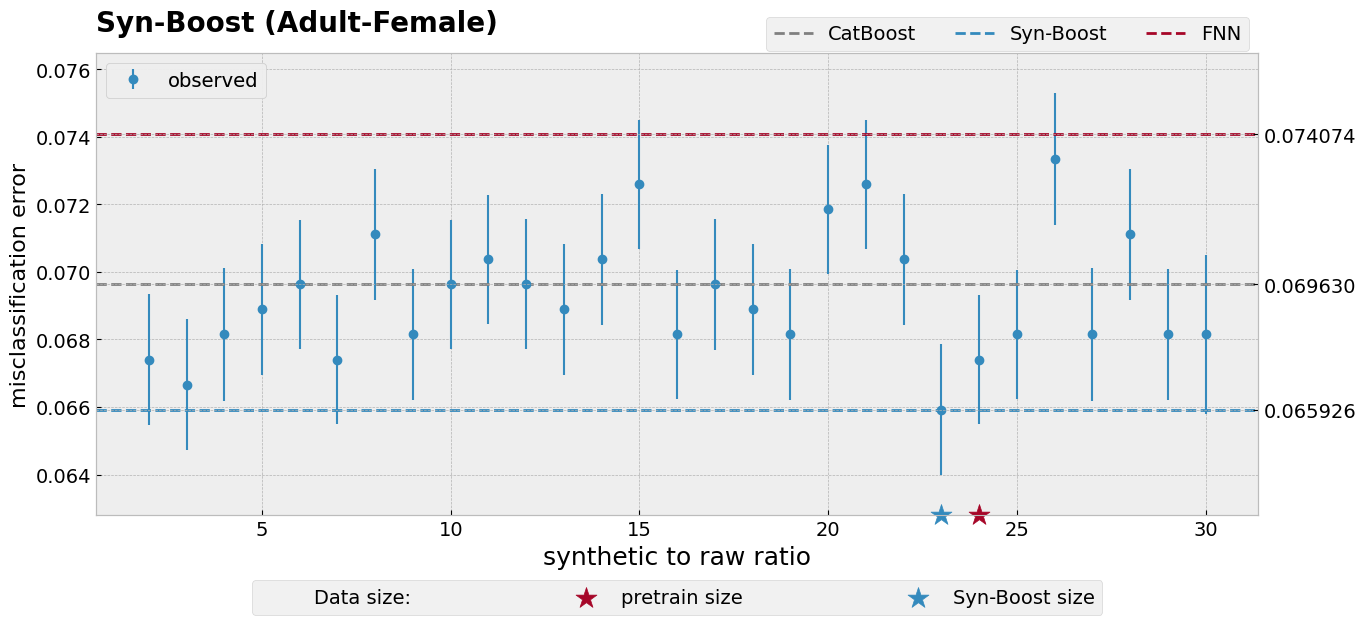

In [20]:
fake_to_real_ratio = result_female["rhos"]
best_score_list = 1 - np.array(result_female["scores"])
best_score_catboost = 1 - score_catboost
nn_best_score = 1 - score_fnn

syngen_size = fake_to_real_ratio[np.argmin(best_score_list)]  # tuned syngen size
myspline = MySpline(fake_to_real_ratio, best_score_list, n_interior_knots=5, k=2)


xnew = np.linspace(fake_to_real_ratio.min(), fake_to_real_ratio.max(), 300)
y_pred, y_pred_se = myspline.pred(xnew)

fig, ax = plt.subplots(figsize=(15, 6))


# 1. add scatter plot of observed data and fitted spline
# ## Option 1: smoothing spline and fitted values
# spline_obs = ax.scatter(
#     fake_to_real_ratio,
#     best_score_list,
#     marker="s",
#     label="observed",
#     # mew=2,
#     # linestyle="-",
#     # markersize=8,
#     # linewidth=2,
# )
# spline_fitted = ax.plot(xnew, y_pred, "-", label="fitted")
# se_scale = 1.96
# ax.fill_between(
#     xnew,
#     y_pred - se_scale * y_pred_se,
#     y_pred + se_scale * y_pred_se,
#     alpha=0.2,
#     color="C0",
# )


# initial_legend = plt.legend(
#     handles=[spline_obs, spline_fitted[0]],
#     loc="upper right",
#     fontsize=14,
#     bbox_to_anchor=[1, 0.8],
# )
## Option 2: error bar based on spline regression model
x, y = fake_to_real_ratio[1:], best_score_list[1:]
_, y_pred_se = myspline.pred(x)
sigma_hat = myspline.sigma_hat
y_se = np.sqrt(y_pred_se**2 + sigma_hat**2)

spline_fitted = ax.errorbar(
    x, y, yerr=y_se, fmt="o", elinewidth=1.5, label="observed"
)

initial_legend = plt.legend(
    handles=[spline_fitted],
    loc="upper left",
    fontsize=14,
    bbox_to_anchor=[0, 1],
)
plt.gca().add_artist(initial_legend)

y_min, y_max = ax.get_ylim()
y_min, y_max = min(y_min, nn_best_score, best_score_list.min()), max(
    y_max, nn_best_score, best_score_list.max()
)
y_min, y_max = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
ax.set_ylim(y_min, y_max)


# 2. add horizontal lines for baseline, FNN-reference and best syn-boost error curve
tuned_value = best_score_list.min()
error_catboost = ax.axhline(
    best_score_catboost, linestyle="--", color="grey", label="CatBoost"
)
error_synboost = ax.axhline(tuned_value, linestyle="--", color="C0", label="Syn-Boost")
error_fnn = ax.axhline(nn_best_score, linestyle="--", color="C1", label="FNN")

ax2 = ax.twinx()
ax2.set_yticks([best_score_catboost, tuned_value, nn_best_score])

ax.tick_params(axis="both", which="major", labelsize=14)
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(axis="both", which="major", labelsize=14)

first_legend = plt.legend(
    handles=[error_catboost, error_synboost, error_fnn],
    loc="upper right",
    fontsize=14,
    ncol=3,
    bbox_to_anchor=[1, 1.1],
)
plt.gca().add_artist(first_legend)


# 3. add legends of sizes: pretrain size and tuned Syn-Boost size
size_marker_kargs = {
    "y": y_min,
    "marker": "*",
    "zorder": 10,
    "clip_on": False,
    "s": 250,
}
size_title = plt.plot([], marker="", ls="")[0]
size_pretrain = ax.scatter(
    x=24,
    color="C1",
    label="pretrain size",
    **size_marker_kargs,
)
size_synboost = ax.scatter(
    x=syngen_size, color="C0", label="Syn-Boost size", **size_marker_kargs
)
plt.legend(
    handles=[size_title, size_pretrain, size_synboost],
    loc="upper center",
    bbox_to_anchor=[0.5, -0.12],
    ncol=4,
    fontsize=14,
    columnspacing=8,
    labels=["Data size:", "pretrain size", "Syn-Boost size"],
)

ax.set_xlabel("synthetic to raw ratio", fontsize=18)
ax.set_ylabel("misclassification error", fontsize=16)
ax.set_title(
    "Syn-Boost (Adult-Female)",
    weight="bold",
    fontsize=20,
    loc="left",
    y=1.03,
)

In [16]:
print(
    "Syn-Boost over CatBoost:",
    (best_score_catboost - tuned_value) / best_score_catboost * 100,
)
print("Syn-Boost over FNN:", (nn_best_score - tuned_value) / nn_best_score * 100)

Syn-Boost over CatBoost: 5.319148936170143
Syn-Boost over FNN: 10.999999999999972
